In [27]:
import numpy as np
import pandas as pd

import acquire
import prepare
import model

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using saas.csv or log data from API usage or store_item_sales

In [2]:
#df = pd.read_csv('big_df.csv', index_col=0)

In [3]:
#df = prep_data(df)
#df.to_csv('prep_store_modeling.csv')

In [4]:
df = pd.read_csv('prep_store_modeling.csv')
df.ds = pd.to_datetime(df.ds, format='%Y %m %d')
df = df.set_index('ds').sort_index()

In [5]:
df.head(2)

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0


1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [6]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [7]:
# resample by month, sum
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [8]:
train.shape, validate.shape, test.shape

((31, 2), (18, 2), (13, 2))

In [9]:
train.head()

,dollars_sold,items_sold
ds,,
2013-01-31 00:00:00+00:00,2447368.20,454904.0
2013-02-28 00:00:00+00:00,2469765.97,459417.0
2013-03-31 00:00:00+00:00,3319815.58,617382.0
2013-04-30 00:00:00+00:00,3666901.23,682274.0
2013-05-31 00:00:00+00:00,4102278.40,763242.0


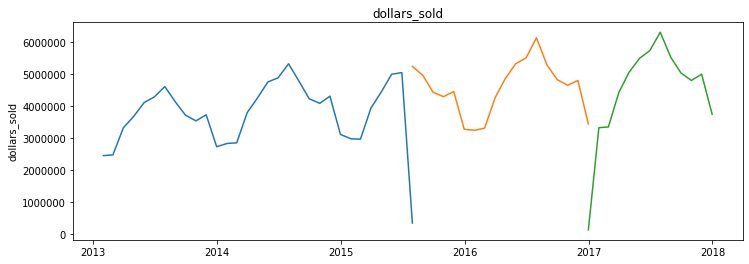

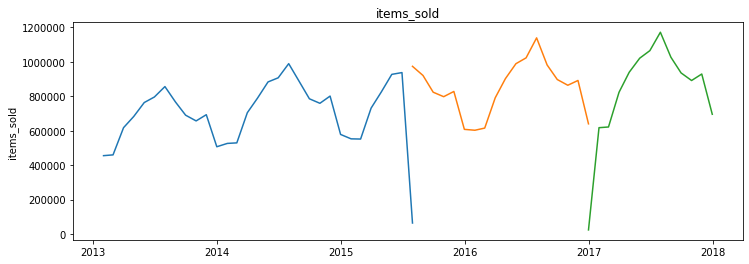

In [10]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

*Functions*

In [11]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [12]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [13]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

#### Simple Average

Make Predictions

In [14]:
dollars = round(train['dollars_sold'].mean(),2)
dollars

3757236.12

In [15]:
# uses the model to make predictions in a df
def make_predictions():
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

In [16]:
yhat_df = make_predictions()

In [17]:
yhat_df.head(2)

,dollars_sold
ds,
2015-07-31 00:00:00+00:00,3757236.12
2015-08-31 00:00:00+00:00,3757236.12


Plot: Actual vs. Predicted Values

dollars_sold -- RMSE: 1140145


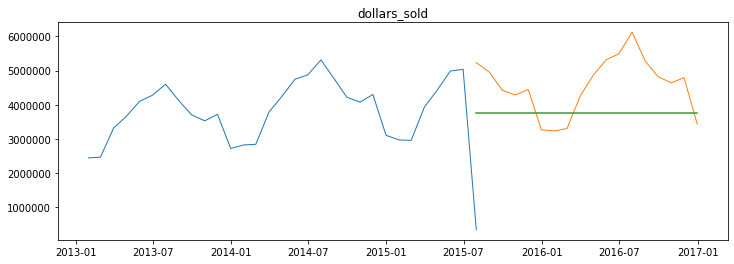

In [18]:
plot_and_eval('dollars_sold')

Evaluate

In [19]:
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = 'dollars_sold')
eval_df

,model_type,target_var,rmse
0,simple_average,dollars_sold,1140145.0


#### Moving Average

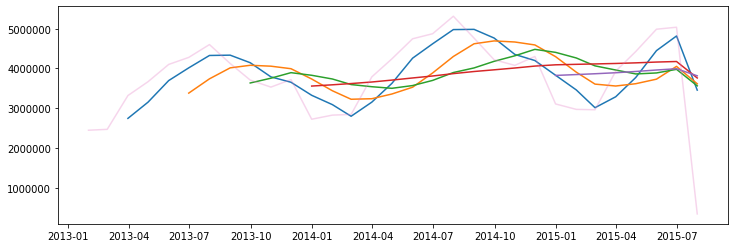

In [20]:
plt.figure(figsize=(12,4))
plt.plot(train['dollars_sold'].rolling(3).mean())
plt.plot(train['dollars_sold'].rolling(6).mean())
plt.plot(train['dollars_sold'].rolling(9).mean())
plt.plot(train['dollars_sold'].rolling(12).mean())
plt.plot(train['dollars_sold'].rolling(24).mean())
plt.plot(train['dollars_sold'].rolling(36).mean())
plt.plot(train['dollars_sold'], alpha=.3)

Make Predictions

In [21]:
period = 3

dollars = round(train['dollars_sold'].rolling(period).mean()[-1], 2)
dollars

3456161.17

In [22]:
yhat_df = make_predictions()
yhat_df.head()

,dollars_sold
ds,
2015-07-31 00:00:00+00:00,3456161.17
2015-08-31 00:00:00+00:00,3456161.17
2015-09-30 00:00:00+00:00,3456161.17
2015-10-31 00:00:00+00:00,3456161.17
2015-11-30 00:00:00+00:00,3456161.17


Plot: Actual vs. Predicted Values

dollars_sold -- RMSE: 1369920


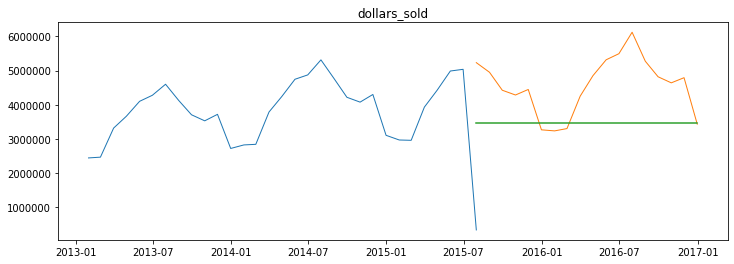

In [23]:
plot_and_eval('dollars_sold')

Evaluate

In [24]:
eval_df = append_eval_df(model_type = '3m_moving_avg', 
                            target_var = 'dollars_sold')

eval_df

,model_type,target_var,rmse
0,simple_average,dollars_sold,1140145.0
1,3m_moving_avg,dollars_sold,1369920.0


In [25]:
periods = [1, 6, 9, 12, 24]

for p in periods: 
    dollars = round(train['dollars_sold'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm_moving_avg'
    eval_df = append_eval_df(model_type = model_type, target_var = 'dollars_sold')

In [26]:
eval_df

,model_type,target_var,rmse
0,simple_average,dollars_sold,1140145.0
1,3m_moving_avg,dollars_sold,1369920.0
2,1m_moving_avg,dollars_sold,4297991.0
3,6m_moving_avg,dollars_sold,1244797.0
4,9m_moving_avg,dollars_sold,1284467.0
5,12m_moving_avg,dollars_sold,1137247.0
6,24m_moving_avg,dollars_sold,1099218.0


#### Holt's Linear Trend

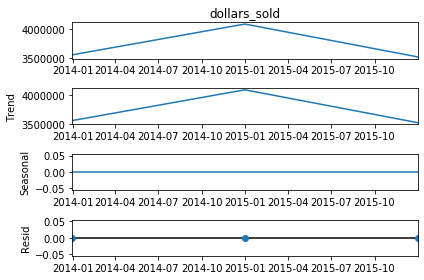

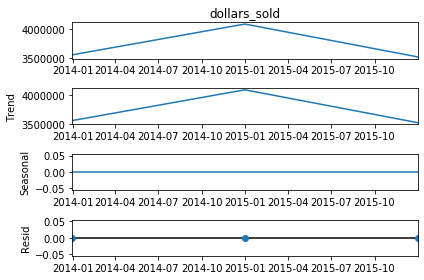

In [32]:
# seasonal decomposition
sm.tsa.seasonal_decompose(train['dollars_sold'].resample('Y').mean()).plot()

Make Predictions

In [33]:
model = Holt(train['dollars_sold'], exponential=False, damped=True)
model = model.fit(optimized=True)
yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
yhat_df['dollars_sold'] = round(yhat_items, 2)

In [35]:
yhat_df.head()

,dollars_sold
ds,
2015-07-31 00:00:00+00:00,5048739.46
2015-08-31 00:00:00+00:00,-695277.78
2015-09-30 00:00:00+00:00,-924727.84
2015-10-31 00:00:00+00:00,-975453.31
2015-11-30 00:00:00+00:00,-986667.39


In [39]:
#Holt alternate
model = Holt(train['dollars_sold'], exponential=False)
model = model.fit(smoothing_level=.1, 
                      smoothing_slope=.1, 
                      optimized=False)
yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
yhat_df['dollars_sold'] = round(yhat_items, 2)

In [41]:
yhat_df.head()

,dollars_sold
ds,
2015-07-31 00:00:00+00:00,4596459.52
2015-08-31 00:00:00+00:00,4172029.66
2015-09-30 00:00:00+00:00,4172984.77
2015-10-31 00:00:00+00:00,4173939.88
2015-11-30 00:00:00+00:00,4174894.98


Plot: Actual vs. Predicted Values

dollars_sold -- RMSE: 5395424


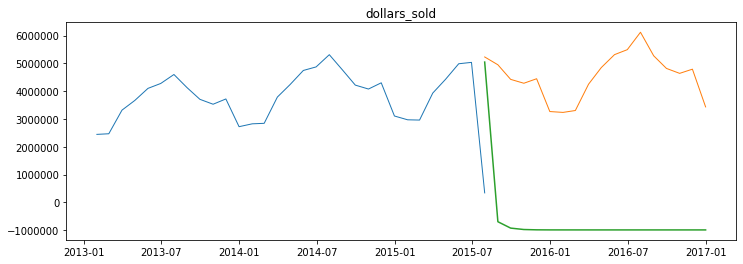

In [36]:
plot_and_eval('dollars_sold')

dollars_sold -- RMSE: 869186


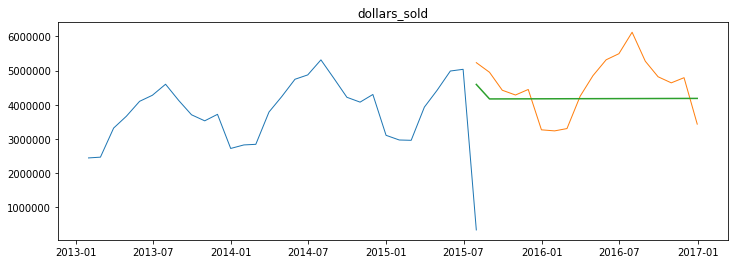

In [42]:
# holt alternate
plot_and_eval('dollars_sold')

Evaluate

In [37]:
eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = 'dollars_sold')

In [43]:
#holt alternate
eval_df = append_eval_df(model_type = 'holts_alternate', 
                            target_var = 'dollars_sold')

In [44]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
8,holts_alternate,dollars_sold,869186.0
6,24m_moving_avg,dollars_sold,1099218.0
5,12m_moving_avg,dollars_sold,1137247.0
0,simple_average,dollars_sold,1140145.0
3,6m_moving_avg,dollars_sold,1244797.0
4,9m_moving_avg,dollars_sold,1284467.0
1,3m_moving_avg,dollars_sold,1369920.0
2,1m_moving_avg,dollars_sold,4297991.0
7,holts_optimized,dollars_sold,5395424.0


#### Previous Year

In [46]:
# re-split
train = df[:'2015'].resample('M').sum()
validate = df['2016'].resample('M').sum()
test = df['2017'].resample('M').sum()

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(36, 2)
(12, 2)
(12, 2)


,dollars_sold,items_sold
ds,,
2013-01-31 00:00:00+00:00,2447368.20,454904.0
2013-02-28 00:00:00+00:00,2469765.97,459417.0
2013-03-31 00:00:00+00:00,3319815.58,617382.0
2013-04-30 00:00:00+00:00,3666901.23,682274.0
2013-05-31 00:00:00+00:00,4102278.40,763242.0


Make Predictions

In [47]:
yhat_df = train['2015'] + train.diff(12).mean()

In [48]:
pd.concat([yhat_df.head(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-01-31 00:00:00+00:00,3.329175e+06,618998.166667
2016-01-31 00:00:00+00:00,3.237958e+06,602439.000000


In [50]:
yhat_df.index = validate.index

Plot: Actual vs. Predicted Values

dollars_sold -- RMSE: 75034


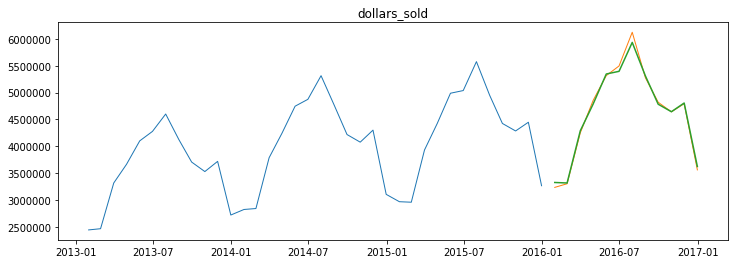

In [51]:
plot_and_eval('dollars_sold')

Evaluate

In [52]:
eval_df = append_eval_df(model_type = 'previous_year', 
                            target_var = 'dollars_sold')

In [54]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,previous_year,dollars_sold,75034.0
8,holts_alternate,dollars_sold,869186.0
6,24m_moving_avg,dollars_sold,1099218.0
5,12m_moving_avg,dollars_sold,1137247.0
0,simple_average,dollars_sold,1140145.0
3,6m_moving_avg,dollars_sold,1244797.0
4,9m_moving_avg,dollars_sold,1284467.0
1,3m_moving_avg,dollars_sold,1369920.0
2,1m_moving_avg,dollars_sold,4297991.0
7,holts_optimized,dollars_sold,5395424.0


##### Test on Out of Sample Data

In [55]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [56]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [59]:
rmse_dollars = sqrt(mean_squared_error(test['dollars_sold'], 
                                       yhat_df['dollars_sold']))
rmse_dollars

197043.72547373656

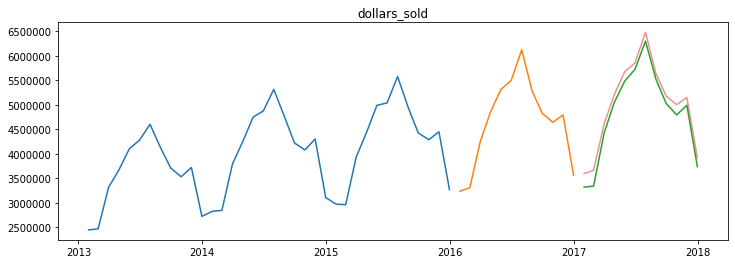

In [57]:
final_plot('dollars_sold')

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.

In [60]:
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [61]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2018-01-31 05:49:12+00:00,3.676734e+06,6.837912e+05
2018-02-28 05:49:12+00:00,3.698421e+06,6.878542e+05
2018-03-31 05:49:12+00:00,4.777891e+06,8.891522e+05
2018-04-30 05:49:12+00:00,5.405692e+06,1.005347e+06
2018-05-31 05:49:12+00:00,5.842629e+06,1.087171e+06


2. Return a dataframe with the `month`, `store_id`, `y-hat`, and the confidence intervals (y-hat lower, y-hat upper).

3. Plot the 2018 monthly sales predictions.

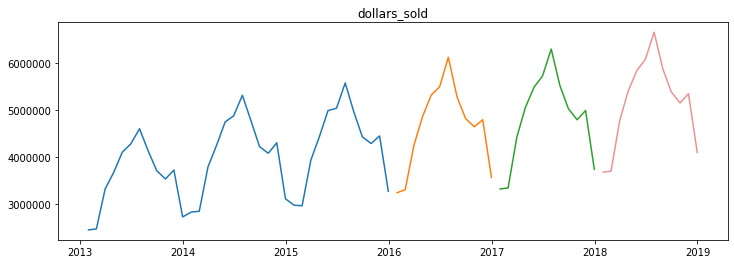

In [62]:
final_plot('dollars_sold')